In [1]:
using JLD2
using Random

include("data_structures.jl");
include("data_sampling_helpers.jl")
include("plotting.jl");

# Sampling ground truths

In [8]:
# Dimension & hyperparameters
D = 2
ALPHA = 1.0
Ii = 20         # objects per category
O = 18          # percepts per object

hyper1 = ObjectAwareHDPHyperparams(
    m0     = [-0.5, -0.5], 
    k_clu  = 1.0,
    k_obj  = 5.0,
    k_per  = 10.0,
    sigma2 = 1,
    alpha  = ALPHA
)
category1 = sample_category(j=1, Ii=Ii, O=O, d=D, hyper=hyper1, rng=MersenneTwister(53));
@save "ground_truth_category1.jld2" hyper1 category1

hyper2 = ObjectAwareHDPHyperparams(
    m0     = [0.5, 0.5], 
    k_clu  = 1.0,
    k_obj  = 5.0,
    k_per  = 10.0,
    sigma2 = 2,
    alpha  = ALPHA
)
category2 = sample_category(j=2, Ii=Ii, O=O, d=D, hyper=hyper2, rng=MersenneTwister(56)); # 43, 53, 54, 56
@save "ground_truth_category2.jld2" hyper2 category2

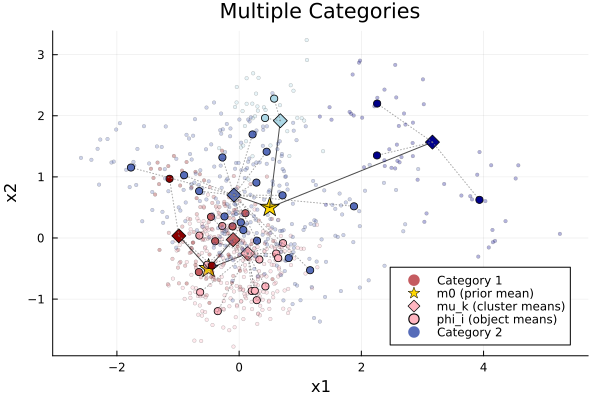

In [9]:
plot_categories([category1, category2], [hyper1, hyper2], plot_circles=false)

# Train/test split & sampling percepts

## Pseudocode for constructing training/test set

Within each category, 

10 objects & 50 percepts in training
- Skewed: [18, 8, 6, 5, 4, 3, 2, 2, 1, 1]
- Uniform: 5 percepts/objects 

10 objects & 50 percepts in test
- 5 percepts/objects

Use sample_category() to sample 20 objects, each with 18 percepts / category
Construct the sets s.t.
- Each object can be the most dominant one
- Each object can appear in both training and test
- If an object is not the most dominant one in training / is part of test set, randomly sample the number of percepts needed

Get permutation of object ids 1-20. The first 10 becomes training (with frequency in this order) and the last 10 becomes test.

## Sampling the train/test splits for model training and testing

In [4]:
cat1_splits = Vector{CategoryTrainTest}(undef, 0)
cat2_splits = Vector{CategoryTrainTest}(undef, 0)

for seed in 1:60
    push!(cat1_splits, train_test_split_sample_percepts(category1; rng=MersenneTwister(seed)))
    push!(cat2_splits, train_test_split_sample_percepts(category2; rng=MersenneTwister(seed)))
end

@save "train_test_splits.jld2" cat1_splits cat2_splits

## Visualize sample train/test splits and percept samples

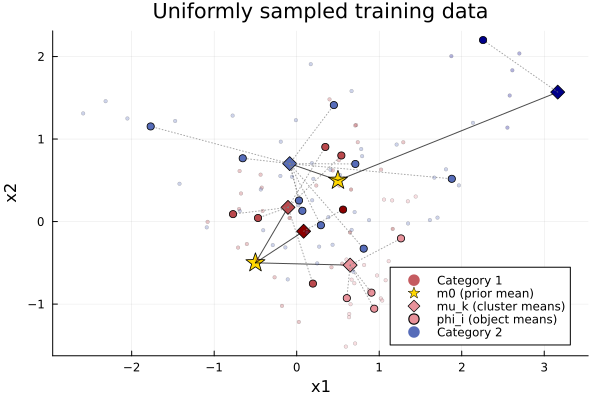

In [5]:
category1_train_uniform = CategorySample(category1.j, category1.sigma2, category1.mus, cat1_splits[9].train_objects_uniform);
category2_train_uniform = CategorySample(category2.j, category2.sigma2, category2.mus, cat2_splits[9].train_objects_uniform);
plot_categories([category1_train_uniform, category2_train_uniform], [hyper1, hyper2], 
                title="Uniformly sampled training data", plot_circles=false)

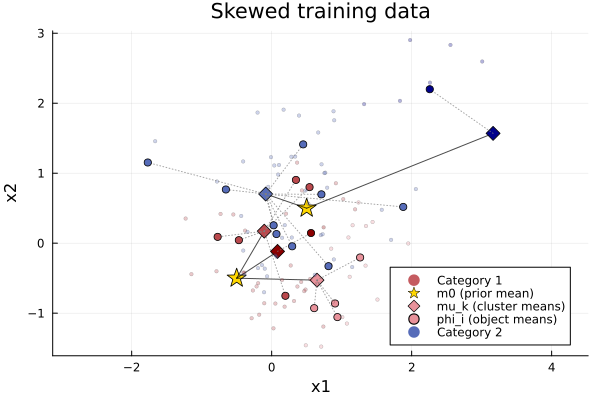

In [6]:
category1_train_skewed = CategorySample(category1.j, category1.sigma2, category1.mus, cat1_splits[9].train_objects_skewed);
category2_train_skewed = CategorySample(category2.j, category2.sigma2, category2.mus, cat2_splits[9].train_objects_skewed);
plot_categories([category1_train_skewed, category2_train_skewed], [hyper1, hyper2], 
                title="Skewed training data", plot_circles=false)

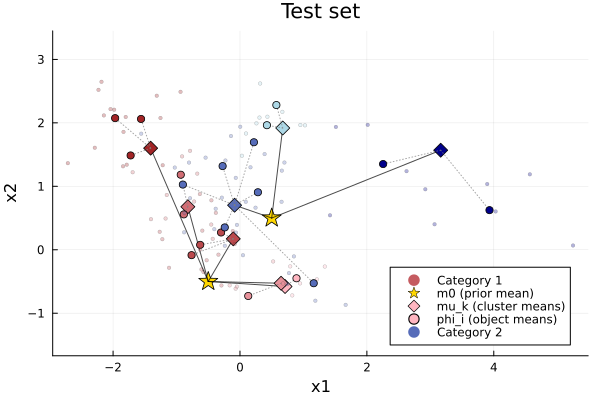

In [7]:
category1_test = CategorySample(category1.j, category1.sigma2, category1.mus, cat1_splits[9].test_objects);
category2_test = CategorySample(category2.j, category2.sigma2, category2.mus, cat2_splits[9].test_objects);
plot_categories([category1_test, category2_test], [hyper1, hyper2], title="Test set", plot_circles=false)